This notebook uses statsmodel to run a logistic regression on both of the events explored in this project (1: CCRB rules that the conduct occurred, 2: CCRB rules that the conduct violated rules). 

The goal of doing this is to explore these events with a model and package that allows for easier inferential analysis. Specifically, I was curious whether the disparities in rulings across complainant race/ethnicity identified through EDA hold when controlling for other variables. 

Conclusion: the disparities did not hold; the complainant ethnicity coefficients were not statistically significant in the logistic regression. This was overall a positive finding; it suggests that there is not racial bias in CCRB rulings.

# Import packages and data

In [18]:
import pickle
import numpy as np
import pandas as pd 

import statsmodels.api as sm 

In [19]:
df_raw = pd.read_pickle('../data/processed_data.pickle')
df_raw.head()

,unique_mos_id,first_name,last_name,command_now,shield_no,complaint_id,month_received,year_received,month_closed,year_closed,...,contact_reason_orig,outcome_description_orig,precinct_alpha,precinct_2020,percent_unemployed_mean,percent_unemployed_median,percent_nohs_mean,percent_nohs_median,percent_poc_mean,percent_poc_median
0,26748,Kenneth,Cullen,PBBX,0,3158,3,1998,8,2000,...,PD suspected C/V of violation/crime - bldg,Arrest - assault (against a PO),P_79,79.0,12.022911,11.100386,19.937815,19.248120,73.174068,80.632008
1,17067,Michael,Vento,C R C,5566,3432,10,1998,5,2000,...,C/V intervened on behalf of/observed encounter...,Arrest - OGA,P_40,40.0,16.684955,13.935231,38.574401,37.617555,97.052903,99.580420
2,17067,Michael,Vento,C R C,5566,3432,10,1998,5,2000,...,C/V intervened on behalf of/observed encounter...,Arrest - OGA,P_40,40.0,16.684955,13.935231,38.574401,37.617555,97.052903,99.580420
3,16150,Michael,Cronin,BARRIER,348,3479,11,1998,6,2000,...,NaN,No arrest made or summons issued,P_46,46.0,14.723453,13.793103,34.149993,34.388366,98.124749,99.240122
4,16150,Michael,Cronin,BARRIER,348,3479,11,1998,6,2000,...,NaN,No arrest made or summons issued,P_46,46.0,14.723453,13.793103,34.149993,34.388366,98.124749,99.240122


In [20]:
# define numeric and categorical features, targets
numeric_features = ['mos_age_incident', 'complainant_age_incident', 'complaint_age', 'officer_cumcount',
                    'command_rank_num', 'percent_unemployed_mean', 'percent_nohs_mean']

categorical_features = ['mos_ethnicity', 'mos_gender', 'complainant_ethnicity', 'complainant_gender',
                        'fado_type', 'contact_reason', 'outcome_description']

targets = ['ruling_conduct_occurred','ruling_conduct_violated_rules']

In [21]:
# only keep variables that will be included in model
df = df_raw[numeric_features+categorical_features+targets]
df.shape

(28318, 16)

In [22]:
df.isnull().sum()

mos_age_incident                   0
complainant_age_incident           0
complaint_age                      0
officer_cumcount                   0
command_rank_num                   0
percent_unemployed_mean           24
percent_nohs_mean                 24
mos_ethnicity                      0
mos_gender                         0
complainant_ethnicity              0
complainant_gender                 0
fado_type                          0
contact_reason                   128
outcome_description                0
ruling_conduct_occurred            0
ruling_conduct_violated_rules      0
dtype: int64

In [23]:
# drop missing values
df = df.dropna()
df.shape

(28168, 16)

In [24]:
# create dummy variables
df = pd.get_dummies(df, columns=categorical_features,drop_first=True)

# Model 1: conduct occurred
While there were not meaningful differences across race/ethnicity in this aspect of the CCRB rulings, I'll run a logistic regression on this dataset just to be thorough

In [9]:
# create X and y
X1 = df.drop(targets, axis=1)
y1 = df['ruling_conduct_occurred']

In [10]:
# fit model
log_reg1 = sm.Logit(y1, X1).fit() 

Optimization terminated successfully.
         Current function value: 0.647385
         Iterations 6


In [33]:
# print summary
print(log_reg1.summary()) 

                              Logit Regression Results                             
Dep. Variable:     ruling_conduct_occurred   No. Observations:                28168
Model:                               Logit   Df Residuals:                    28131
Method:                                MLE   Df Model:                           36
Date:                     Sun, 22 Nov 2020   Pseudo R-squ.:                 0.06490
Time:                             13:50:04   Log-Likelihood:                -18236.
converged:                            True   LL-Null:                       -19502.
Covariance Type:                 nonrobust   LLR p-value:                     0.000
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
mos_age_incident                                                0.0096  

# Model 2: conduct violated rules
This is the ruling where EDA did identify some differences across complainant race/ethnicity (the CCRB ruling was in favor of the police in 54% of Black-complainant cases and 52% of Hispanic-complainant cases, vs 49% and 47% for Asian- and White- complainant cases, respectively).

In [27]:
# filter out any "unsubstantiated" complaints and save as new dataframe
indexNames = df[df['ruling_conduct_occurred'] == 0].index
df2 = df.drop(indexNames)
df2_raw = df_raw.drop(indexNames)

# define X and y for 'violated rules' model
X2 = df2.drop(targets, axis=1)
y2 = df2['ruling_conduct_violated_rules']

In [12]:
X2.shape

(14653, 37)

In [13]:
# fit model
log_reg2 = sm.Logit(y2, X2).fit() 

Optimization terminated successfully.
         Current function value: 0.575902
         Iterations 9


In [14]:
# print summary
print(log_reg2.summary()) 

                                 Logit Regression Results                                
Dep. Variable:     ruling_conduct_violated_rules   No. Observations:                14653
Model:                                     Logit   Df Residuals:                    14616
Method:                                      MLE   Df Model:                           36
Date:                           Tue, 12 Jan 2021   Pseudo R-squ.:                  0.1675
Time:                                   20:42:08   Log-Likelihood:                -8438.7
converged:                                  True   LL-Null:                       -10136.
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
mos_age_incident        

I'm surprised, but it looks like none of the complainant ethnicity variables are statistically significant, suggesting they aren't associated with the ruling outcome when controlling for all other features in the model. 

Below I'll just confirm that the patterns I saw in my EDA are present in this dataset, just to be 100% I'm looking at the same data in both places/didn't make a mistake:

In [15]:
# confirm that the disparity in the simple cross tabulation still holds true!
pd.crosstab(index=df2['complainant_ethnicity_Black'],columns=df2['ruling_conduct_violated_rules'],normalize='index')

ruling_conduct_violated_rules,0,1
complainant_ethnicity_Black,,
0,0.499831,0.500169
1,0.544113,0.455887


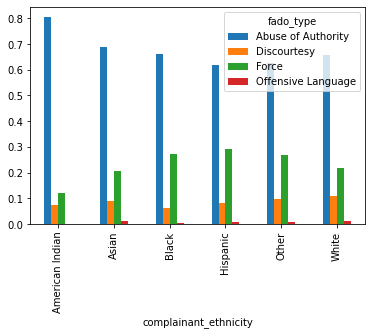

In [32]:
# explore whether differences in complaint type are drivers of differences... doesn't seem to be a silver bullet
pd.crosstab(index=df2_raw['complainant_ethnicity'],columns=df2_raw['fado_type'],normalize='index').plot(kind='bar');